<a href="https://colab.research.google.com/github/redinbluesky/nlp-with-transformers/blob/main/02-텍스트 분류.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  텍스트 분류 목차
* [Chapter 0 개요](#chapter0)
* [Chapter 1 데이터셋](#chapter1)
    * [Chapter 1-1 허깅스페이스 데이터셋 처음사용하기](#chapter1-1)
    * [Chapter 1-2 데이터셋에서 데이터프레임으로](#chapter1-2)
    * [Chapter 1-3 클래스 분포 살펴보기](#chapter1-3)
    * [Chapter 1-4 트윗 길이 확인](#chapter1-4)
* [Chapter 2 텍스트에서 토큰으로](#chapter2)
    * [Chapter 2-1 문자 토큰화](#chapter2-1)
    * [Chapter 2-2 단어 토큰화](#chapter2-2)
    * [Chapter 2-3 부분단어 토큰화](#chapter2-3)
    * [Chapter 2-4 전체 데이터셋 토큰화하기](#chapter2-4)    
* [Chapter 3 텍스트 분로 모델 훈련하기](#chapter3)    
    * [Chapter 3-1 트랜스모머를 특성 추출기로 사용하기](#chapter3-1)
    * [Chapter 3-2 트랜스포머 미세 튜닝하기](#chapter3-2)

## Chapter 0 개요 <a class="anchor" id="chapter0"></a>
1. 텍스트 분류는 NLP에서 매우 일반적인 작업이다.
    - 고객의 피드백의 카테고리 분류, 이메일의 스팸 분류, 텍스트의 감성 분석등에 활용된다.
    - 예를 들어 테슬라 같은 회사의 사람들이 신차의 지붕을 좋아하는지 알아보기 위해 아래와 같은 트위터 포스터를 분석한다고 가정한다.
        - 제품에 드러낸 감정 상태, 'anger', 'joy' 같은 감정을 분류한다.
        - DistiBERT 모델을 사용하여 텍스트 분류 작업을 수행하는 방법을 알아본다.
            - DistiBERT는 BERT 모델의 경량화 버전으로 분류 모델을 몇 분만에 훈려할 수 있다.
        - BERT 모델을 훈련해야 한다면 사전 훈련 모델의 체크포인트를 바꾸면된다.
            - 체크포인트라 트랜스포머 아키텍처로 로드왼 일련 가중치이다.
    
            ![twitter](image/02_01_twitter.png)
        
        - 허깅페이스 생태계의 라이브러리인 테이터셋, 토크나이져, 트랜스포머스를 사용해 원시 텍스트에서 시작해 트윗을 추론하는 미세 듀닝된 모델을 구축한다.
        - 트랜스포머를 훈련하는 전형적인 과정은 아래의 그림과 같다.
        
            ![transformer-fine-tuning](image/02_02_transformer_fine_tuning.png)
        


## Chapter 1 데이터셋 <a class="anchor" id="chapter1"></a>
1. 감정 감지기를 개발하기 위해 영어로 작성된 트위터 메시지에 감정이 어떻게 표현되는지 연구 한 논문의 데이터셋을 사용한다.
    - '긍정적', '부정적'으로 나뉘는 대부분의 감성 분석데이터 셋과 달리, 이 데이터셋은 '분노, 협오, 두려움, 기뿜, 슬품, 놀람'의 여섯개 감정 카테고리를 포함한다.
    - 트위이 주어지면 여섯개의 감정 중 하나로 분류하는 모델을 훈련한다.


### Chapter 1-1 허깅페이스 데이터셋 처음 사용하기 <a class="anchor" id="chapter1-1"></a>
1. 허깅페이스 데이터셋 사용하여 데이터셋을 다운로드한다.
    - 허깅페이스 데이터셋 라이브러리는 NLP 데이터셋을 다운로드하고 전처리하는데 유용한 도구이다.

In [2]:
# list_datasets() 함수를 사용하여 허브에서 제공하는 데이터셋 목록을 출력한다.
from huggingface_hub import list_datasets

all_datasets = [dataset.id for dataset in list_datasets()]
print(f"허브에서 제공하는 데이터셋의 개수: {len(all_datasets)}")
print("처음 10개의 데이터셋 이름:")
print(all_datasets[:10])

허브에서 제공하는 데이터셋의 개수: 630472
처음 10개의 데이터셋 이름:
['google/mobile-actions', 'MiniMaxAI/VIBE', 'nvidia/NitroGen', 'bigai/TongSIM-Asset', 'OpenMed/Medical-Reasoning-SFT-GPT-OSS-120B', 'openai/frontierscience', 'spatialverse/SAGE-3D_Collision_Mesh', 'spatialverse/SAGE-3D_InteriorGS_usdz', 'nvidia/Nemotron-Agentic-v1', 'nvidia/Nemotron-Pretraining-Code-v2']


3. emotion 데이터셋을 다운로드한다.
    - 이 객체는 파이썬 딕셔너리와 비슷하며, 일반적인 딕셔너리 사용법으로 개별 분할을 참조할 수 있다
    - 훈련데이터 셋의 첫 번째 샘플은 아래와 같다.
        - {'text': 'i didnt feel humiliated', 'label': 0}
        - 'text' 키는 트윗을 포함하고, 'label' 키는 감정 카테고리를 나타낸다.
        - 레이블 0은 '분노'에 해당한다.
    - 데이텃 셋은 열기반 데이터 셋이으로 데이터 타입은 features 속성에 표시된다.
        - features 속성은 데이터셋의 각 열에 대한 정보를 포함한다.
        - 'text' 열은 문자열로 구성되고, 'label' 열은 정수로 구성된다.
        - {'text': Value('string'), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])}
    - 슬라이스 연산자를 사용하여 데이터셋의 하위 집합을 추출할 수 있다.
        - 예를 들어 처음 5개의 샘플을 가져오려면 train_ds[:5]를 사용한다.
        - 이 경우 딕셔너리 값이 개별 항목이 되지 않고 리스트로 반환된다.
        <pre>
        {
            'text': ['i didnt feel humiliated', 
                     'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 
                     'im grabbing a minute to post i feel greedy wrong', 
                     'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 
                     'i am feeling grouchy'
                    ], 
            'label': [0, 0, 3, 2, 3]
        }
        </pre>

4. 허브에 필요한 데이터셍이 없는경우 로컬 파일에서 데이터셋을 로드할 수 있다.
    - load_dataset() 함수는 CSV, JSON, 텍스트 파일과 같은 다양한 형식의 로컬 파일에서 데이터셋을 로드하는 기능을 제공한다.
    - 예를 들어, 로컬 CSV 파일에서 데이터셋을 로드하려면 다음과 같이 할 수 있다.
        - dataset = load_dataset('csv', data_files='path/to/your/file.csv')
        - data_files 매개변수는 로드할 파일의 경로를 지정한다.
    - 이 방법을 사용하면 허브에 없는 사용자 정의 데이터셋도 쉽게 로드할 수 있다.

In [10]:
# emotion 데이터셋을 다운로드한다.
from datasets import load_dataset

emotions = load_dataset("emotion")
print(emotions)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [15]:
train_ds = emotions['train']
print(train_ds)
print(f"len(train_ds): {len(train_ds)}")

print(train_ds[0])

print(train_ds.features)

print(train_ds['text'][:5])


Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})
len(train_ds): 16000
{'text': 'i didnt feel humiliated', 'label': 0}
{'text': Value('string'), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])}
['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


### Chapter 1-2 데이터셋에서 데이터프레임으로 <a class="anchor" id="chapter1-2"></a>
1. Dataset 객체를 판다스 DataFrame으로 변환하면 데이터 분석 및 시각화에 유용하다.
    - set_format() 메서드를 사용하여 Dataset 객체를 DataFrame 형식으로 변환할 수 있다.
    - 내부 데이터 포맷(아파치 에로우 테이블)은 바꾸지 않으므로 나중에 필요에 따라 다른 포맷으로 변환이 가능하다

In [ ]:
import pandas as pd

emotions.set_format(type='pandas')
df = emotions['train'][:]

# 처음 5개의 샘플을 출력한다.
#   - 레이블이 정수로 출력된다.
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [55]:
def label_in2str(row):
    # int2str() 메서드를 사용하여 정수 레이블을 문자열 레이블로 변환한다.
    return emotions['train'].features['label'].int2str(row)

# 데이터프레임 생성 (cell 10에서 했던 것처럼)
emotions.set_format(type='pandas')
df = emotions['train'][:]

df["label_name"] = df["label"].apply(label_in2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Chapter 1-3 클래스 분포 살펴보기 <a class="anchor" id="chapter1-3"></a>
1. 모델을 훈련하기 전 샘플의 클래스 분포를 조사하는 것이 좋다.
    - 클래스 분포가 편향된 데이터셋은 훈련 손실과 평가 지표 측면에서 다른 처리법이 필요하다.
    - 판다스의 맷플롯립을 사용하면 빠르게 클래스 분포를 시각화할 수 있다.

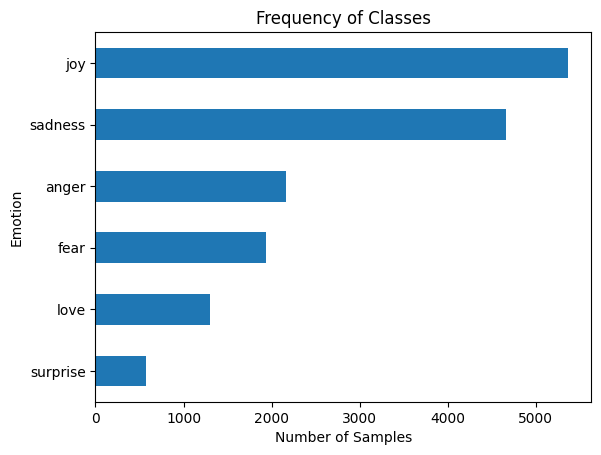

In [19]:
import matplotlib.pyplot as plt

df['label_name'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.xlabel("Number of Samples")
plt.ylabel("Emotion")
plt.show()

7. 데이터셋의 불균형이 심한것을 볼 수 있다.
    - "joy"와 "sadness" 클래스는 다른 클래스에 비해 훨씬 더 많은 샘플을 가지고 있다.
    - "love"와 "surprise" 클래스는 상대적으로 적은 샘플을 가지고 있다. 
    - 소수 클래스는 랜덤하게 오버샘플링하고, 다수 클래스는 랜덤하게 언더샘플링하는 방법을 사용할 수 있다.
    - 클래스의 대표성이 부족하다면 레이블된 데이터를 더 많이 수집한다. 
    - 샘플링 전략은 일반적으로 훈련/검증 데이터를 분리한 후 훈련데이터에만 적용한다.

### Chapter 1-4 트윗 길이 확인 <a class="anchor" id="chapter1-4"></a>
1. 트랜스포머 모델은 최대 문맥 크기라는 최대 입력 시퀸스 길이가 있다.
    - DistilBERT 모델의 경우 최대 입력 시퀸스 길이는 512 토큰이다.
    - 트윗당 단어 토분포를 보면 감정에 따른 드윗 길이를 추정할 수 있다.

2. 그래프를 보면 각 감정 트윗 길이는 15개 단어 정도이다.
    - 최대 입력 시퀸스 길이인 512 토큰보다 훨씬 작다.
    - 따라서 모든 트윗을 모델에 입력할 수 있다.
    - 텍스트가 모델의 문맥 크기보다 길면 잘라야하는데, 이 경우 잘린 텍스트에 중요한 정보가 포함되어 있을 경우 성능이 저하될 수 있다.

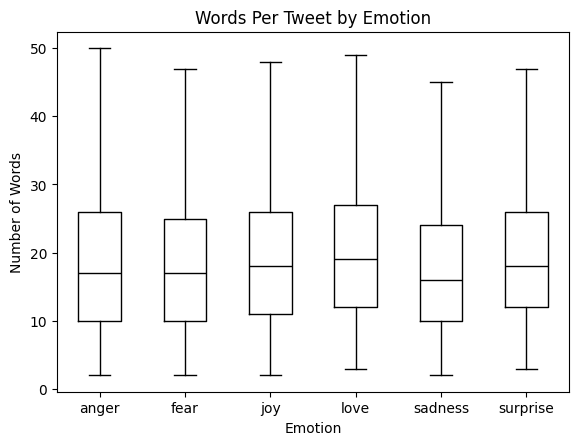

In [23]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
# 각 감정별 트윗당 단어 수의 분포를 박스플롯으로 시각화한다.
#   - showfliers=False 옵션을 사용하여 이상치를 표시하지 않는다.
df.boxplot("Words Per Tweet", by="label_name", grid=False, color='black', showfliers=False)
plt.title("Words Per Tweet by Emotion")
plt.suptitle("")
plt.xlabel("Emotion")
plt.ylabel("Number of Words")
plt.show()

emotions.reset_format()

## Chapter 2 텍스트에서 토큰으로 <a class="anchor" id="chapter2"></a>
1. DistilBERT 같은 트랜스포머 모델은 원시 문자역을 입력으로 받지 못한다.
    - 대신 텍스트가 토큰화되어 수치 벡터로 인코딩되어야 한다.
    - 토큰화는 문자열을 모델이 사용하는 기본 단위로 분할하는 단계이다.
    - 토큰화 전력은 몇가지가 있으며 단어를 부분단위로 나누기 위한 최적 분할은 일반적으로 말뭉치에서 학습된다.
    - 문자 토큰화와 단어 토큰화에 대해서 알아보자

### Chapter 2-1 문자 토큰화 <a class="anchor" id="chapter2-1"></a>
1. 문자 토큰화는 각 문자를 개별 토큰으로 분할하는 가장 단순한 토큰화 방법이다.
    - 예를 들어 "hello"라는 단어는 문자 토큰화 후 ['h', 'e', 'l', 'l', 'o']로 분할된다.
    - 문자 토큰화는 철자 오류나 신조어가 많은 텍스트에서 유용할 수 있다.
    - 그러나 문자 토큰화는 긴 시퀸스를 생성하여 모델의 계산 비용을 증가시킬 수 있다.

In [14]:
# 파이썬 str 객체 내부는 배열이다. 문자 수준의 토큰화는 간단히 리스트 변환으로 구현할 수 있다.
text = "Tokenizing text is a core take of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 'k', 'e', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


2. 모델은 모든 문자가 정수로 매핑된다고 가정한다. 예를 들어, 'a'는 1, 'b'는 2, 'c'는 3 등으로 매핑된다.
    - 이 과정을 수치화라고 한다.

In [15]:
# 토큰화된 문자를 정수로 매핑한다.
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [3]:
# 어휘사전에 있는 각 문자를 고유한 정수로 바꾸는 매핑 딕셔너리를 만든다.
input_ids = [token2idx[ch] for ch in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 12, 8, 0, 14, 9, 0, 3, 2, 4, 1]


3. 각 토큰이 고유한 숫자 식별자로 매핑됐다. 다음 단계로 input_ids를 원-핫 벡터의 2D 텐서로 변환한다.
    - 원-핫 인코딩은 각 토큰을 고유한 벡터로 표현하는 방법이다.
    - 벡터의 길이는 어휘 사전의 크기와 같고, 토큰에 해당하는 인덱스는 1이고 나머지는 0이다.

4. 트랜스포머 TV 시리즈의 캐릭터 이름을 인코딩한다고 가정한다.
    - "Optimus Prime", "Bumblebee", "Megatron"이라는 이름이 있다.

In [16]:
import pandas as pd

categorical_df = pd.DataFrame({"NAME":["Bumblebee", "Megatron", "Optimus Prime"], "Label ID":[0, 1, 2]})
print(categorical_df)

# 이름 사이에 가상의 순서가 만들어진다는 문제가 있다.
#   - 신경망이 이름들 사이의 관계를 잘못 학습할 수 있다.
#   - 예를 들어, "Optimus Prime"이 "Bumblebee"보다 크다고 잘못 학습할 수 있다.
# 이를 해결하기 위해 원-핫 인코딩을 사용한다.
#   - 범주마다 새 열을 만들어 이름이 범주에 해당하면 1, 아니면 0을 넣는다.
pd.get_dummies(categorical_df["NAME"])

            NAME  Label ID
0      Bumblebee         0
1       Megatron         1
2  Optimus Prime         2


,Bumblebee,Megatron,Optimus Prime
0,True,False,False
1,False,True,False
2,False,False,True


5. DataFrame은 행이 원-핫 벡터이고, 하나의 항목만 1인 2D 텐서이다.
    - input_ids를 보면 원소 사이에 순서가 생기는 문제가 발생한다.
    - 파이토치로 inputs_ids를 원-핫 인코딩하는 방법은 다음과 같다.

In [17]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
# 38개의 입력 토큰 각각에 대해 어휘사전 크기만큼의 원-핫 벡터를 생성한다.
#   - 결과는 (38, 20) 크기의 2D 텐서이다.
#   - num_classes 매개변수에 어휘사전의 크기를 전달한다. 
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
print(one_hot_encodings.shape)
print(one_hot_encodings)

torch.Size([38, 20])
tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],

/tmp/ipykernel_1809/4269678888.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids)


6. 38개의 입력 토큰 각각에 20차원의 원-핫 벡터가 생성되었다.
    - 어휘사전을 구성하는 고유한 문자의 개수가 20개이기 때문이다.

In [18]:
# 첫 번째 벡터를 조사한다.
#   - input_ids[0] 값에 해당하는 위체에 1이 들어가있는지 확인한다.
print(f"토큰: {tokenized_text[0]}")
print(f"텐서 인덱스: {input_ids[0]}")
print(f"원-핫 인코딩 벡터: {one_hot_encodings[0]}")

토큰: T
텐서 인덱스: 5
원-핫 인코딩 벡터: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


7. 간단한 예제를 통해 문자 수준의 토큰화는 텍스트의 구조를 무시하고 전체 문자열을 문자 스트림으로 처리하는 것을 확인했다.
    - 이는 철자 오류나 신조어가 많은 텍스트에서 유용할 수 있지만, 단어 같은 언어 구조를 이 데이터에서 학습해야 한다는 단점이 있다.
    - 이런 단점 때문에 일반적으로 문자 토큰화보다는 단어 토큰화를 선호한다.

### Chapter 2-2 단어 토큰화 <a class="anchor" id="chapter2-2"></a>
1. 텍스트를 문자가 아니라 단어로 분할하고 각 던어를 전수로 매핑하는 것을 단어 토큰화라고 한다.
    - 처음부터 단어를 사용하면 모델이 문자에서 단어를 학습하는 단계가 생략되어 훈련 과정의 복잡도가 감소한다.

In [19]:
# 공백을 사용해 텍스트를 토큰화한다.
tokenized_text = text.split(" ")
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'take', 'of', 'NLP.']


2. 각 단어를 하나의 ID에 매핑한다.
    - 구두점이 고려되지 않아서 "NLP."와 "NLP"는 동일한 토큰으로 처리된다.
    - 단어의 활용형, 철자 오류등이 포함되면 어휘사전이 급격히 증가하는 단점이 있다.
    - 일부 토크나이져에는 구두점을 추가하는 규칙이 있다.

3. 어휘사전이 크면 신경망의 파라미터 역시 많이 필요하다.
    - 100만개의 고유 단어가 있고, 이 100만 차원의 입력 벡터를 신경망의 첫 번째 층에서 1,000차원의 출력 벡터로 매핑한다고 가정하자.
    - 첫 번째 층의 가중치 행렬은 100만 개 * 1,000 = 10억 개의 파라미터가 필요하다.
    - 이는 총 15억 개의 파람미터를 가진 가장 큰 GPT-2 모델의 첫 번째 층과 비슷하다.

4. 어휘사전의 크기를 제한하는 일반적인 방법은 드물게 등장하는 단어를 무시하는 것이다.
    - 예를 들어, 어휘사전에서 가장 자주 등장하는 5만 개의 단어만 유지하고 나머지는 모두 '<UNK>' 토큰으로 대체할 수 있다.
    - '<UNK>' 토큰은 'unknown'의 약자로, 어휘사전에 없는 단어를 나타내는 데 사용된다.
    - 이렇게 하면 어휘사전의 크기를 줄이고 모델의 계산 비용을 감소시킬 수 있지만 정보 손실이 발생할 수 있다.

### Chapter 2-3 부분단어 토큰화 <a class="anchor" id="chapter2-3"></a>
1. 부분단어 토큰화는 기본적으로 문자 토큰화와 단어 토큰화의 장점을 결합한 방법이다.
    - 드물게 등장하는 단어를 더 작은 부분 단위로 분할하여 어휘사전의 크기를 줄인다.
        - 예를 들어, "unhappiness"라는 단어는 부분단어 토큰화 후 ['un', 'happi', 'ness']로 분할될 수 있다.
    - 자주 등장하는 단어를 고유한 항목으로 유지한다.

2. WorPiece 토크나이져는 부분단어 토큰화를 구현하는 인기 있는 방법 중 하나이다.
    - BERT 모델에서 사용되며, 어휘사전을 구성하는 부분단어를 학습하기 위해 통계적 방법을 사용한다.
    - WordPiece 토크나이져는 자주 등장하는 단어를 고유한 토큰으로 유지하고, 드물게 등장하는 단어를 더 작은 부분 단위로 분할한다.

In [14]:
# 트랜스포머스에서 제공하는 사전훈련된 모델과 연관된 토크나이져를 빠르게 로드하는 AutoTokenizer 클래스를 사용한다.
from transformers import AutoTokenizer

# AutoTokenizer:  체크포인트 이름을 사용해 모델의 설정, 사전훈련된 가중치, 어휘 사전을 자동으로 로드한다.
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [22]:
# 특정 클래스를 수동으로 로드할 수 있다.
from transformers import DistilBertTokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [23]:
# 토크나이져가 제공하는 encode() 메서드를 사용해 텍스트를 토큰화하고 정수로 매핑한다.
encoded_text = tokenizer.encode(text)
print(encoded_text)

[101, 19204, 6026, 3793, 2003, 1037, 4563, 2202, 1997, 17953, 2361, 1012, 102]


In [26]:
# 토크나이져의 convert_ids_to_tokens 메서드를 사용해 정수 시퀀스를 다시 텍스트로 변환한다.
tokens = tokenizer.convert_ids_to_tokens(encoded_text)
print(tokens)

print(tokenizer.convert_tokens_to_string(tokens))

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'take', 'of', 'nl', '##p', '.', '[SEP]']
[CLS] tokenizing text is a core take of nlp. [SEP]


3. 토큰들을 살펴보면 아래와 같은 특징이 있다.
    - '[CLS]'와 '[SEP]' 토큰은 BERT 모델에서 특별한 역할을 한다.
        - '[CLS]' 토큰은 문서의 시작을 나타내며, 분류 작업에서 전체 문서의 표현을 캡처하는 데 사용된다.
        - '[SEP]' 토큰은 문서의 끝을 나타내며, 문장 구분에도 사용된다.
    - 토큰이 모두 소문자인 것을 볼 수 있다.
        - 이는 DistilBERT 모델이 소문자만 처리하도록 훈련되었기 때문이다.
    - "tokenizing" 단어는 "token"과 "##izing"으로 분할되었다.
        - "##" 접두사는 이 토큰이 이전 토큰에 이어지는 부분 단어임을 나타낸다.
        - 이는 WordPiece 토크나이져가 드물게 등장하는 단어를 더 작은 부분 단위로 분할하는 방식을 보여준다.
    - 접두사가 붙은 토큰은 문자열로 다시 바꿀 때 앞의 토큰과 붙여쓴다. 

### Chapter 2-4 전체 데이터셋 토큰화하기 <a class="anchor" id="chapter2-4"></a>
1. 전체 말뭉치를 토큰화하기 위해 DatasetDict의 map() 메서드를 사용한다.
    - map() 메서드는 데이터셋의 각 샘플에 대해 지정된 함수를 적용하는 기능을 제공한다.
    - 새 행과 열을 만드는데 데 사용할 수도 있다.

In [15]:
def tokenize(batch):
    '''
        데이터셋의 각 배치에 대해 토큰화를 수행하는 함수
        padding=True:  입력 시퀀스의 길이를 맞추기 위해 패딩을 추가한다.
        truncation=True:  최대 길이를 초과하는 시퀀스를 잘라낸다.
    ''' 
    return tokenizer(batch['text'], padding=True, truncation=True)

In [ ]:
# 토큰 2개를 tokensize(batch) 함수에 전달하여 토큰화를 수행한다.
print(tokenize(emotions['train'][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


2. input_ids의 첫 번째 원소가 두 번재 원소보다 짧으므로 패딩이 추가된 것을 볼 수 있다.
   - 특수토큰 [CLS] 101와 [SEP] 102도 추가된 것을 볼 수 있다.
   - attention_mask도 생성되었는데, 이는 모델이 패딩 토큰을 무시하도록 돕는다.
   - 이미지를 통해 설명하면 아래와 같다.

       ![padding-truncation](image/02_03_padding_truncation.png)

In [16]:
# map 함수를 통해 전체 데이터셋에 토큰화를 적용한다.
#   - map 매서드는 말뭉치에 있는 모든 샘플에 개별적으로 작동한다.
#   - 배치 처리를 사용하려면 batched=True로 설정한다.
#   - batch_size=None으로 설정하면 가능한 한 많은 샘플을 하나의 배치로 처리한다.
#   - 결과는 input_ids와 attention_mask 열이 추가된 DatasetDict 객체이다.
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
print(emotions_encoded["train"].column_names)


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask']


## Chapter 3 텍스트 분류 모델 훈련하기 <a class="anchor" id="chapter3"></a>
1. DistilBERT 같은 모델은 텍스트 시퀸스에 있는 마스킹된 단어를 예측하도록 사전 훈련된다.
    - 하지만 언어 모델을 바로 텍스트 분류에 사용하지는 못한다.

2. 인코더 기반 모델의 구조는 아래와 같다.
    - 먼저 텍스트를 토큰화해 원-핫 벡터로 변환한다.
        - 토크나이져 어휘사전의 크기가 토큰 인코딩의 차원이 된다.
        - 어휘시전은 보통 2만 ~ 2백만 개의 고유 토큰으로 구성된다.
    - 토큰 인코딩을 저차원 공간의 벡터인 토큰 임베딩으로 변환한다.
    - 토큰 임베딩을 인코더 블럭 층에 통과시켜 은닉상태를 만든다.
    - 각 은닉상태는 언어 모델링의 사전 훈련 목표를 달성하기 위해 마스킹된 입력 토큰을 예측하는 층으로 전달된다.
    - 분류 작업에서 이 언어 모델링 층을 분류 층을 변경한다.  

        ![encoder-based-model](image/02_04_encoder_based_model.png)

3. 파이토치는 토큰 임벧이을 위해 원-핫 벡터를 만든는 단계를 건너뛴다.
    - 행렬에 원-핫 벡터를 곱하면 행력에서 열 하나를 선택한 결과가 나으므로, 토큰 ID에 해당하는 열을 가져온는 식으로 대체한다.

4. 모델을 훈련하는 두가지 방법이있다. 
    - 특성 추출: 사전 훈련된 모델을 수정하지 않고 은닉 상태를 특성으로 사용해 분류 모델을 훈련한다.
    - 미세 튜닝: 사전 훈련된 모델의 파라미터도 업데이트 하기 위해 전체 모델을 앤드-투-앤드 방식으로 훈련한다. 

### Chapter 3-1 트랜스포머를 특성 추출기로 사용하기 <a class="anchor" id="chapter3-1"></a>
1. 트랜스포머는 특성 추출기로 사용하기 편하다.
    - 아래의 그림처럼 훈련하는 동안 바디의 가중치를 동결하고 은닉 상태를 분류 모델의 특성으로 사용한다.
    - 이 방식은 작거나 얕은 모델을 빠르게 훈련하는 장점이 있다.
    - 훈련되는 모델로는 신경망 분류 층이거나 랜덤 프레스트 같이 그레이디언트에 의존하지 않는 기법 등이 있다.
    - 이 방법은 은닉 상태를 한번만 미리 계산하면 되므로 GPU 메모리를 절약할 수 있다.

        ![transformer-feature-extractor](image/02_05_transformer_feature_extractor.png)

2. 트랜스포머서의 AutoModel 클래스를 사용하여 사전 훈련된 모델을 로드한다.
    - AutoModel 클래스는 모델 아키텍처를 자동으로 감지하고 해당 모델을 로드하는 기능을 제공한다.
    - DistilBERT 모델의 경우 'distilbert-base-uncased' 체크포인트를 사용한다.

In [32]:
import torch
# AutoModel 클래스를 사용해 DistilBERT 모델을 로드한다.
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# AutoModel 클래스는 토큰 인코딩을 임베딩으로 변환한 다음 인코더 스택에 통과시켜 은닉 상태를 반환한다.
model = AutoModel.from_pretrained(model_ckpt).to(device)

3. 트랜스포머스는 텐서플로나 JAX와의 긴밀한 상호운영성을 제공한다.
    - 코드 몇출만 바꾸면 선호하는 딥러닝 프레임워크에서 사전 훈련된 모델을 로드할 수 있다.

4. 하나의 문자열에 대한 마지막 은닉 상태를 추출한다.
    - 문자열을 인코딩하고 토큰을 파이토치 텐서로 변환한다.

In [33]:
text = "this is a test"
# 문자열을 인코딩하고 토큰을 파이토치 텐서로 변환한다.
#   - return_tensors="pt" 옵션을 사용해 파이토치 텐서로 반환한다.
inputs = tokenizer(text, return_tensors="pt")
print(f"입력 텐서 크기: {inputs['input_ids'].size()}")

입력 텐서 크기: torch.Size([1, 6])


5. 모델이 있는 장치로 옯기고 입력을 전달한다.
   - 모델은 마지막 마지막 은닉 상태 하나만 반환한다.

In [34]:
inputs = {key:v.to(device) for key, v in inputs.items()}
print(inputs)
with torch.no_grad():
    # **inputs 구문을 사용해 딕셔너리의 키-값 쌍을 언패킹하여 모델에 전달한다.
    outputs = model(**inputs)

print(outputs)


{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]], device='cuda:0')}
BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [ ]:
# 은닉상태의 크기는 [배치 크기, 시퀀스 길이, 은닉층 크기]이다.
#   - 6개의 입력 토큰마다 768차원의 벡터가 반환됐다.
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [35]:
# 보통 [CLS] 토큰에 해당하는 첫 번째 은닉 상태를 문장 표현으로 사용한다.
#   - BERT 모델에서는 [CLS] 토큰이 문장 전체의 의미를 담고 있다.
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

6. 전체 데이터세에서 같은 작업을 수행하고 hidden_state 열을 만들어 이런 벡터를 저장한다.

In [36]:
def extract_hidden_states(batch):
    '''
        데이터셋의 각 배치에 대해 마지막 은닉 상태를 추출하는 함수
    '''
    # 모델 입력을 모델이 있는 장치로 옮긴다.
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    
    # 마지막 은닉 상태를 추출한다.
    with torch.no_grad():
        last_hidden_states = model(**inputs).last_hidden_state
    # [CLS] 토큰에 해당하는 첫 번째 은닉 상태를 반환한다.
    #   - .cpu().numpy() 메서드를 사용해 CPU로 옮기고 넘파이 배열로 변환한다.
    #   - 딕셔너리로 반환해야 map 메서드가 올바르게 작동한다.
    return {'hidden_state': last_hidden_states[:,0].cpu().numpy()}

In [37]:
# input_ids와 attention_mask 열을 "torch" 형식으로 설정한다.
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# 은닉상태를 한번에 추출한다.
#   - batch_size를 지정하지 않았기 때문에 기본값 1000이 사용된다.
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [38]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

7. 특성 행렬 만들기
    - 전처리된 데이터셋에 분류 모델을 훈련하기 위한 모든 필요한 정보가 포함되어 있다.
    - 은직 상태를 입력 특성으로 사용하고 레이블을 타켓으로 사용한다.

In [39]:
# 사이킷런 스타일로 특성 행렬과 타겟 벡터를 만든다.
import numpy as np
X_train = np.array(emotions_hidden["train"]["hidden_state"])
x_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((16000, 768), (2000, 768), (16000,), (2000,))

8. 훈련세트 시각화 하기
    - 768차원의 은닉 상태를 시각화하기 어렵기 때문에 UMAP 같은 차원 축소 기법을 사용한다.
    - UMAP는 고차원 데이터를 저차원으로 매핑하는 비선형 차원 축소 기법이다.
    - UMAP를 사용하여 768차원의 은닉 상태를 2차원으로 축소하고 시각화할 수 있다.
    - 시각화 결과를 통해 서로 다른 감정 클래스가 어떻게 분포되어 있는지 확인할 수 있다.

In [41]:
# 사이킷런의 MinMaxScaler를 사용해 특성 행렬을 0과 1 사이로 스케일링한다.
# umap-learn 패키지를 사용해 2D로 차원 축소를 수행한다.
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from umap import UMAP

# 특성 스케일을 0과 1 사이로 조정한다.
X_scaled = MinMaxScaler().fit_transform(X_train)
# UMAP 객체를 생성하고 2D로 차원 축소를 수행한다.
mapper = UMAP(n_components=2, metric='cosine', random_state=42).fit(X_scaled)

# 2D 임베딩을 데이터 프레임을 만든다.
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['label'] = y_train
df_emb.head()

/home/redinblue/anaconda3/envs/pybuild/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,X,Y,label
0,4.066246,2.931603,0
1,-3.396937,4.123374,0
2,5.166740,6.355587,3
3,-2.654216,5.875293,2
4,-3.580272,5.894228,3


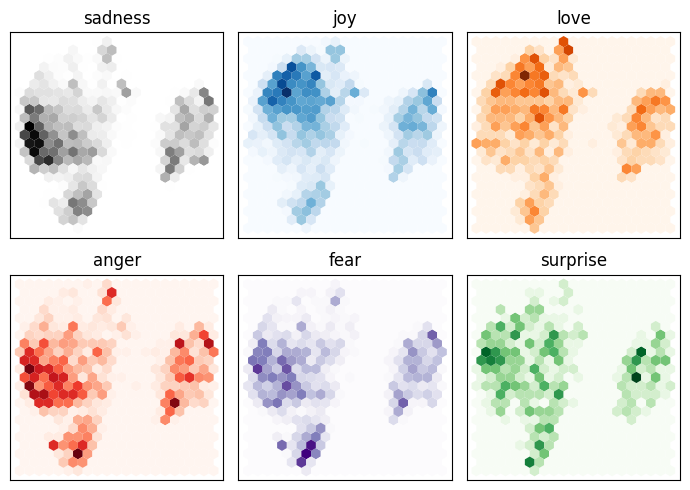

In [42]:
import matplotlib.pyplot as plt

# 각 범주에 대한 샘플의 밀도를 개별로 시각화한다.3
fig, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions['train'].features['label'].names

for i , (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub['X'], df_emb_sub['Y'], gridsize=20, cmap=cmap, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
plt.tight_layout()
plt.show()

9. 그래프에는 확실한 패턴이 보인다.
    - sandness, anger, fear 같은 부정적인 감정은 조금씩 다르게 분포됐지만 차지한 영역은 비슷하다.
    - joy, love는 부정적인 감정과 잘 분리되고 비슷한 영역을 차지한다.
    - suprise는 영역 전체에 골고루 퍼져있다.

10. 간단한 분류 모델 훈련하기
    - 은닉 상태가 감정별로 조검씩 다르지만 일부 감정 사이에믄 명확한 경계가 없기도 하다.
 

In [43]:
# 사이킷런을 통해 간단한 로지스틱 회귀 분류 모델을 훈련한다.
from sklearn.linear_model import LogisticRegression

# 수렴을 보장히기 위해 max_iter=3000으로 설정한다.
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(x_valid, y_valid)

0.633

11. 정확도는 모델이 무작위로 예측한 것보다 더 높다.
    - 불균형한 다중 클래스 데이터셋을 다루기 때문에 이 정확도는 꽤 괜찮은 성능이다.

12. 이 모델이 덜마나 좋은지 단순한 기준 모델과 비교한다.
    - 기준 모델은 가장 빈도가 높은 클래스를 항상 예측하는 모델이다.

In [65]:
# DummyClassifier를 사용해 기준 모델을 만든다.
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(x_valid, y_valid)

0.352

13. 분류 모델의 성능을 자세히 조사하기 위해 오차 행렬(혼돈 행렬)을 사용한다.
    - 오차 행렬은 실제 클래스와 예측 클래스 간의 관계를 시각화하는 도구이다.
    - 오차 행렬을 통해 모델이 어떤 클래스에서 잘못 예측하는지 확인할 수 있다.

In [45]:
# 오차 행렬을 사용하여 모델의 성능을 자세히 조사한다.
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels):
    '''
        오차 행렬을 시각화하는 함수
    '''
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues, values_format='.2f', ax=ax, colorbar=False)
    plt.title("Normalized Confusion Matrix")
    plt.show()

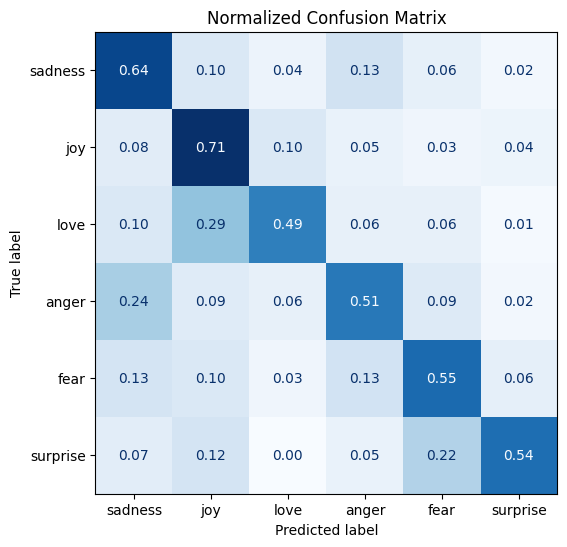

In [46]:
y_pred = lr_clf.predict(x_valid)
plot_confusion_matrix(y_pred, y_valid, labels)

14. anger와 fear은 sandess와 가장 많이 혼동되고, love와 suprise는 joy와 많이 혼동된다.

### Chapter 3-2 트랜스포머 미세 튜닝하기 <a class="anchor" id="chapter3-2"></a>
1. 미세 튜닝 방식에서는 은닉 상태를 고정된 특성으로 사용하지 않고 아래의 그림과 같이 전체 모델을 훈련한다.
    - 이를 위해 분류 헤드는 미분 가능해야한다.
    - 분류 모델에 입력으로 사용하는 은닉상태를 훈련하면 분류 작업체 적합하지 않은 데이터를 다룬다는 문제를 회피할 수 있다.
    - 초기 은닉 상태는 훈련하는 동안에 모델 손실이 감소하도록 수정되고 따라서 성능이 높아진다.

        ![transformer-fine-tuning](image/02_06_transformer_fine_tuning.png)

2. 트랜스포머스의 Trainer API를 사용하여 미세 튜닝을 간단하게 수행할 수 있다.
    - Trainer API는 모델 훈련과 평가를 위한 고수준 인터페이스를 제공한다.
    - Trainer API를 사용하면 모델 훈련, 평가, 예측 등의 작업을 쉽게 수행할 수 있다.


In [50]:
# 사전 훈련된 모델 로드하기
# AutoModelForSequenceClassification 클래스를 사용해 사전훈련된 트랜스포머 모델을 로드한다.
#   - 사전 훈련된 모델 출력 위에 베이스 모델과 함께 쉽게 훈련할 수 있는 분류 헤드가 있다.
from transformers import AutoModelForSequenceClassification

# 예측할 레이블의 개수를 지정한다.
num_labels = 6

# 모델 일부가 랜덤하게 초기화된다는 경고를 보낸다.
#   - 분류 헤드가 아직 훈련되지 않았기 때문에 이는 정상이다.
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)).to(device)

In [4]:
# 성공 지표 정의하기
# 훈련하는 동안 성능을 모니터링하기 위해 Trainer에 사용할 comput_metrics 함수를 정의한다.
#   - EvalPredictions 객체(predictionsd와 label_ids 속성을 가진 네임드 튜플)를 입력으로 받는다.
#   - 모델의 F1 스코어를 계산하여 반환한다.
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'f1': f1, 'accuracy': acc}    

In [6]:
# 모델 훈련하기
#   - 허깅스페이스에 로그인 후 훈련을 위한 파라미터를 정의한다.
from huggingface_hub import notebook_login

notebook_login()

In [20]:
#    - 훈련 파라미터를 정의하기위해 TrainingArguments 클래스를 사용한다.
from transformers import TrainingArguments, Trainer

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(
    model_name,
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
    save_strategy="epoch",
    load_best_model_at_end=True,
    log_level="error"
)

In [21]:
# Trainer 객체를 만들고 모델을 미세 튜닝한다.
trainer = Trainer(
    model,
    training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"],
    tokenizer=tokenizer
)
trainer.train()

/tmp/ipykernel_1085/2773872592.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.793600,0.264828,0.915647,0.915500
2,0.210600,0.172523,0.934013,0.933000
3,0.140300,0.162590,0.930038,0.930000


TrainOutput(global_step=750, training_loss=0.3814724833170573, metrics={'train_runtime': 127.2103, 'train_samples_per_second': 377.328, 'train_steps_per_second': 5.896, 'total_flos': 1080514292544000.0, 'train_loss': 0.3814724833170573, 'epoch': 3.0})

In [22]:
# 오차 행렬을 만들어 훈련 결과를 조금 더 상세히 살펴본다.
#   - 검증 세트에 대한 예측을 만든다.
#   - predict: PredictionOutput 객체를 반환한다.
#       - predictions: 모델의 로짓 예측을 담고 있는 넘파이 배열
#       - label_ids: 실제 레이블을 담고 있는 넘파이 배열
preds_output = trainer.predict(emotions_encoded["validation"])

# 검증세트에 대한 지표확인
preds_output.metrics

{'test_loss': 0.1625896394252777,
 'test_f1': 0.9300376195290229,
 'test_accuracy': 0.93,
 'test_runtime': 1.378,
 'test_samples_per_second': 1451.382,
 'test_steps_per_second': 23.222}

In [24]:
# 각 클래스에 대한 예측 데이터
#   - np.argmax() 메서드를 사용해 로짓 예측에서 가장 높은 값을 가진 인덱스를 선택한다.
import numpy as np
y_pred = np.argmax(preds_output.predictions, axis=1)
print(y_pred)


[0 0 2 ... 1 1 1]


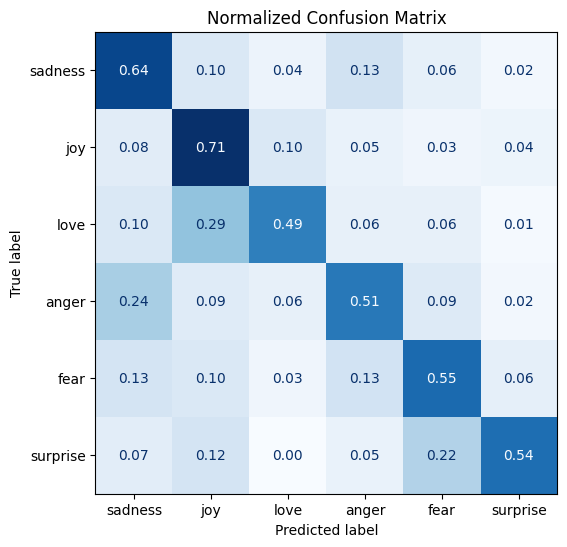

In [ ]:
# 예측을 사용해 오차 행렬을 만든다.
#   - 주대각선 원소 이외에는 거의 0에 가깝다
#   - love와 joy는 여전히 혼동되지만 자연스러운 현사이다.
plot_confusion_matrix(y_pred, y_valid, labels)

In [51]:
# 오류 분석
#   - 모델 손실 기준으로 검증 샘플을 정렬한다.
from torch.nn.functional import cross_entropy

def forward_pass_with_labels(batch):
    '''
        레이블과 함께 모델의 순전파를 수행하는 함수
    '''
    # 모델 입력을 모델이 있는 장치로 옮긴다.
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    labels = batch['label'].to(device)
    
    # 모델 출력과 손실을 계산한다.
    with torch.no_grad():
        outputs = model(**inputs)
        pred_label = torch.argmax(outputs.logits, axis=1)
        loss = cross_entropy(outputs.logits, labels, reduction='none')
    return {'loss': loss.cpu().numpy(), 'pred_label': pred_label.cpu().numpy()}

In [52]:
# map() 메서드를 함수를 적용해 모든 샘플의 손실을 구한다.
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# 손실 값을 계산한다.
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_labels, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [56]:
# 텍스트, 손실, 예측 레이블과 진짜 레이블로 DataFrame을 만든다.
import pandas as pd
emotions_encoded.set_format("pandas")
cols = ["text", "label", "pred_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_in2str)
df_test["pred_label"] = df_test["pred_label"].apply(label_in2str)

In [57]:
# emotions_encoded를 손실 기준으로 정렬한다.
#   - 자못된 레디블을 감지한다.
#   - 데이터셋의 특이사항
#      - 실세계의 데이터셋은 엉성할 수 있다. 특수 문자나 문자역이 예측에 큰 영향을 미치기도한다.
#      - 나쁜 예측을 들여다보면 이런 특성을 찾게 되고, 데이터를 정제하거나 비슷한 샘플을 추가하여 성능을 개선할 수 있다.
df_test.sort_values("loss", ascending=False).head(10)

,text,label,pred_label,loss
1940,i was feeling pretty strange like dinosaur sol...,fear,sadness,2.015952
1981,i spent a lot of time feeling overwhelmed with...,fear,sadness,2.013713
538,i stood for a few minutes more feeling a stran...,fear,sadness,2.008931
128,i knew there were a lot of hormonal things goi...,fear,sadness,2.008585
1881,i usually love being home im starting to feel ...,fear,sadness,2.007926
853,i couldn t help but feel slightly skeptical an...,fear,sadness,2.007315
370,i had struggled through a difficult pregnancy ...,fear,sadness,2.007114
1699,im feeling rather nervous,fear,surprise,2.001509
228,i began feeling shaky my heart was sort of ski...,fear,sadness,2.000704
1855,i felt and still feel really horribly that i s...,fear,sadness,1.999388


In [58]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,pred_label,loss
1667,im feeling really sentimental about things tha...,sadness,sadness,1.619609
1937,im trying to regroup after anatomy as ive been...,sadness,sadness,1.620736
201,i woke up feeling ugly and im sure i looked li...,sadness,sadness,1.622383
768,i already did feel deprived when after claire ...,sadness,sadness,1.622790
838,i was angry at myself for feeling drained and ...,sadness,sadness,1.626194
99,im not trying to sound sarcastic but only tryi...,sadness,sadness,1.626764
188,i was going to tell you more about my trip to ...,sadness,sadness,1.627720
818,i was making up a batch of waffles for breakfa...,sadness,sadness,1.628904
602,id feel so defeated and id have to lick my wounds,sadness,sadness,1.630043
734,i can talk to her about almost anything i want...,sadness,sadness,1.630238


In [59]:
# 모델 저장 및 공유
#   - NLP 커뮤니티는 사전 훈련되고 미세 튜닝된 모델을 공유해 도움을 받는다.
#   - 허깅페이스 허브를 통해 모델을 쉽게 저장하고 공유할 수 있다.
#   - Trainer API를 사요하면 모델의 저장과 공유가 간단해진다.
trainer.push_to_hub(commit_message="Training complete")

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/ParkJuYeong/distilbert-base-uncased-finetuned-emotion/commit/fb445c1ea0175156ce18dd35e6f4db7be6cc70f7', commit_message='Training complete', commit_description='', oid='fb445c1ea0175156ce18dd35e6f4db7be6cc70f7', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ParkJuYeong/distilbert-base-uncased-finetuned-emotion', endpoint='https://huggingface.co', repo_type='model', repo_id='ParkJuYeong/distilbert-base-uncased-finetuned-emotion'), pr_revision=None, pr_num=None)

In [60]:
# 허깅페이스에 업로드한 모델을 다운로드한다.
from transformers import pipeline

model_id = "ParkJuYeong/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

config.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [61]:
# 샘플 트윗으로 파이프라인 테스트
custom_tweets = "I saw a movie today and it was fantastic!"
preds = classifier(custom_tweets, return_all_scores=True)

/home/redinblue/anaconda3/envs/pybuild/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


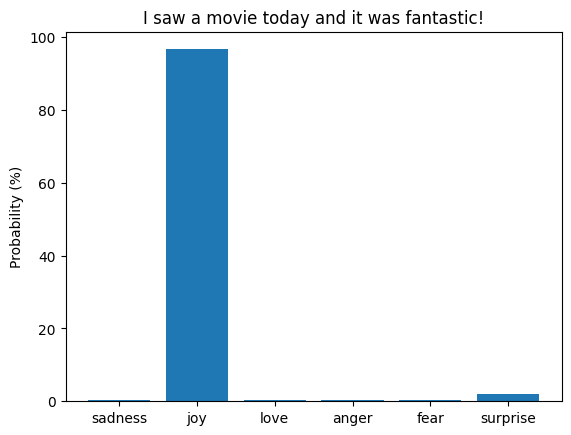

In [62]:
# 각 클래스의 확률을 막대 그래프로 표시
import matplotlib.pyplot as plt
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100*preds_df['score'], color='C0')
plt.title(f"{custom_tweets}")
plt.ylabel("Probability (%)")
plt.show()